## BERT

Based on findings from LSTM notebook. Small bert with Tensorflow preprocessing & encoding layers used.
As it was trained on Windows, nightly builds were used (look into requirements_bert.txt).

Due to small dataset only two sets are present (train & test, no validation set).

In [16]:
%load_ext autoreload
%autoreload 2

import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# text must be loaded for hub to work!
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from official.nlp import optimization

np.random.seed(42)

physical_devices = tf.config.list_physical_devices('GPU')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [17]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


## Data split

In [18]:
X_all = train_df['text']
y_all = train_df['target']

X_all[:3]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
Name: text, dtype: object

In [19]:
X = X_all.to_numpy()
y = y_all.to_numpy()

X[:3]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
      dtype=object)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:3]

array(['Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR',
       '@ZachZaidman @670TheScore wld b a shame if that golf cart became engulfed in flames. #boycottBears',
       "Tell @BarackObama to rescind medals of 'honor' given to US soldiers at the Massacre of Wounded Knee. SIGN NOW &amp; RT! https://t.co/u4r8dRiuAc"],
      dtype=object)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset.take(1)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.int64)>

## Building model

In [35]:
preproces_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
preprocessor = hub.KerasLayer(preproces_url, name='preprocessing')

encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"
encoder = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')

In [37]:
def build_model(preprocessor, encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')    
    encoder_inputs = preprocessor(text_input)    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

model = build_model(preprocessor, encoder)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 5 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [31]:
BATCH_SIZE = 32
epochs = 10

def prepare_training_data(train_dataset, test_dataset, epochs):
    train_dataset_batched = train_dataset.shuffle(100).batch(BATCH_SIZE)
    test_dataset_batched = test_dataset.batch(BATCH_SIZE)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    
    steps_per_epoch = tf.data.experimental.cardinality(train_dataset_batched).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    
    return train_dataset_batched, test_dataset_batched, optimizer, loss, metrics


train_dataset_batched, test_dataset_batched, optimizer, loss, metrics = prepare_training_data(train_dataset, test_dataset, epochs)

In [24]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history = model.fit(x=train_dataset_batched,
                    validation_data=test_dataset_batched,
                    epochs=epochs)

Epoch 1/10
191/191 [==============================] - 458s 2s/step - loss: 0.6226 - binary_accuracy: 0.6472 - val_loss: 0.4230 - val_binary_accuracy: 0.8227
Epoch 2/10
191/191 [==============================] - 450s 2s/step - loss: 0.4225 - binary_accuracy: 0.8175 - val_loss: 0.3955 - val_binary_accuracy: 0.8378
Epoch 3/10
191/191 [==============================] - 440s 2s/step - loss: 0.3333 - binary_accuracy: 0.8592 - val_loss: 0.4208 - val_binary_accuracy: 0.8339
Epoch 4/10
191/191 [==============================] - 430s 2s/step - loss: 0.2776 - binary_accuracy: 0.8904 - val_loss: 0.4736 - val_binary_accuracy: 0.8293
Epoch 5/10
191/191 [==============================] - 429s 2s/step - loss: 0.2145 - binary_accuracy: 0.9161 - val_loss: 0.5627 - val_binary_accuracy: 0.8234
Epoch 6/10
191/191 [==============================] - 431s 2s/step - loss: 0.1798 - binary_accuracy: 0.9298 - val_loss: 0.6099 - val_binary_accuracy: 0.8260
Epoch 7/10
191/191 [==============================] - 431s

48/48 [==============================] - 32s 666ms/step - loss: 0.7528 - binary_accuracy: 0.8194
Loss:  0.7528133988380432
Accuracy:  0.8194352984428406


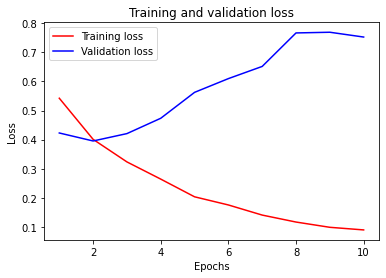

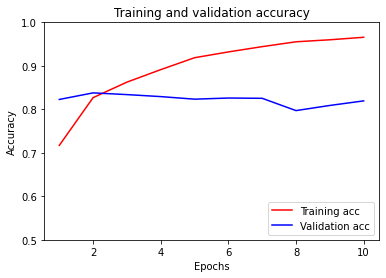

In [26]:
loss, accuracy = model.evaluate(X_test, y_test) # TODO replace
print('Loss: ', loss)
print('Accuracy: ', accuracy)

history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

axes = plt.gca()
axes.set_ylim([0.5, 1])

max_val_acc = f'{np.max(history_dict["val_binary_accuracy"]):.3f}'
mean_val_acc = f'{np.mean(history_dict["val_binary_accuracy"]):.3f}'

# plt.savefig(f'lstm_max{max_val_acc}_mean{mean_val_acc}_embdim{embedding_dim}_lstm{lstm_layer_units}'
#             f'_dense{hidden_layer_units}_drop{dropout_rate}_batch{batch_size}_{iter_count}.png')

plt.show()

In [27]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

[[730 144]
 [131 518]]
Normalized confusion matrix


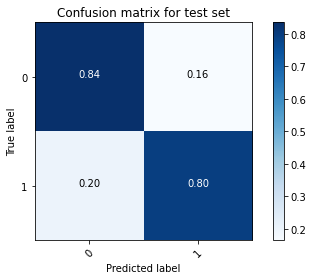

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix for test set',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.print(classification_report(y_test, y_pred_test))
    """
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_pred_test = np.array(model.predict(X_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(cm, [0, 1])

In [29]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       874
           1       0.78      0.80      0.79       649

    accuracy                           0.82      1523
   macro avg       0.82      0.82      0.82      1523
weighted avg       0.82      0.82      0.82      1523



## Cross validation

TRAIN: 5709 TEST: 1904
Epoch 1/4
179/179 [==============================] - 563s 3s/step - loss: 0.6663 - binary_accuracy: 0.6490 - val_loss: 0.4454 - val_binary_accuracy: 0.8036
Epoch 2/4
179/179 [==============================] - 551s 3s/step - loss: 0.4059 - binary_accuracy: 0.8322 - val_loss: 0.4786 - val_binary_accuracy: 0.8104
Epoch 3/4
179/179 [==============================] - 550s 3s/step - loss: 0.3471 - binary_accuracy: 0.8638 - val_loss: 0.4962 - val_binary_accuracy: 0.8088
Epoch 4/4
179/179 [==============================] - 551s 3s/step - loss: 0.2971 - binary_accuracy: 0.8860 - val_loss: 0.4836 - val_binary_accuracy: 0.7988


60/60 [==============================] - 51s 855ms/step - loss: 0.4836 - binary_accuracy: 0.7988
TRAIN LOSS: 0.4835743010044098 / TEST ACCURACY: 0.7988445162773132


TRAIN: 5710 TEST: 1903
Epoch 1/4
179/179 [==============================] - 544s 3s/step - loss: 0.6674 - binary_accuracy: 0.6613 - val_loss: 0.4328 - val_binary_accuracy: 0.8171
Epoch 

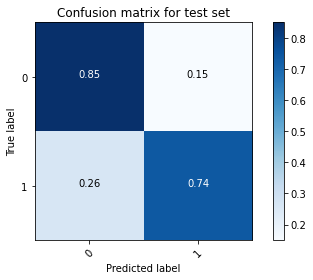

In [45]:
X_cv = X_all.copy()
y_cv = y_all.copy()

CONF_MATRIXES = []

epochs_cv = 4

skf = StratifiedKFold(n_splits=4)
for train_idx, test_idx in skf.split(X_cv, y_cv):
    print('TRAIN:', len(train_idx), 'TEST:', len(test_idx))            
    
    X_train_cv, X_test_cv = X_cv.iloc[train_idx].to_numpy(), X_cv.iloc[test_idx].to_numpy()
    y_train_cv, y_test_cv = y_cv.iloc[train_idx].to_numpy(), y_cv.iloc[test_idx].to_numpy()
    
    train_dataset_cv = tf.data.Dataset.from_tensor_slices((X_train_cv, y_train_cv))
    test_dataset_cv = tf.data.Dataset.from_tensor_slices((X_test_cv, y_test_cv))    
    
    train_dataset_batched_cv, test_dataset_batched_cv, optimizer_cv, loss_cv, metrics_cv = prepare_training_data(
        train_dataset_cv, test_dataset_cv, epochs_cv)     
    
    preprocessor_cv = hub.KerasLayer(preproces_url, name='preprocessing')    
    encoder_cv = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')
    
    model_cv = build_model(preprocessor_cv, encoder_cv)
    model_cv.compile(optimizer=optimizer_cv, loss=loss_cv, metrics=metrics_cv)    
    
    history_cv = model_cv.fit(x=train_dataset_batched_cv,
                              validation_data=test_dataset_batched_cv,
                              epochs=epochs_cv)

    print('\n')
    loss_cv, accuracy_cv = model_cv.evaluate(X_test_cv, y_test_cv)
    print(f'TRAIN LOSS: {loss_cv} / TEST ACCURACY: {accuracy_cv}')
    y_pred_test_cv = np.array(model_cv.predict(X_test_cv) > 0.5).astype('int32')    
    cm = confusion_matrix(y_test_cv, y_pred_test_cv)
    CONF_MATRIXES.append(cm)
    print('\n')

    tf.keras.backend.clear_session()

# overall results
cm = np.array(CONF_MATRIXES).sum(axis=0)
plot_confusion_matrix(cm, [0, 1])